<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [3]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2025-05-27 17:14:10--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2025-05-27 17:14:11--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.06s   

2025-05-27 17:14:11 (102 MB/s) - ‘images_evaluation.zip’ saved [64

In [4]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [5]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names


    alphabet_name = os.path.basename(os.path.normpath(alphabet_directory_path))


    for character_name in os.listdir(alphabet_directory_path):
        character_path = os.path.join(alphabet_directory_path, character_name)

        if not os.path.isdir(character_path):
            continue

        label = f"{alphabet_name}/{character_name}"

        for image_name in os.listdir(character_path):
            if image_name.endswith(".png"):
                image_path = os.path.join(character_path, image_name)
                datax.append(image_path)
                datay.append(label)

    return np.array(datax), np.array(datay)

In [6]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None

    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [7]:
trainx, trainy = read_images('images_background')

In [8]:
testx, testy = read_images('images_evaluation')

In [9]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((19280,), (19280,), (13180,), (13180,))

In [10]:
for a in trainx:
    print(a)
    break

images_background/Hebrew/character22/0487_19.png


## Create samples

In [11]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [12]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

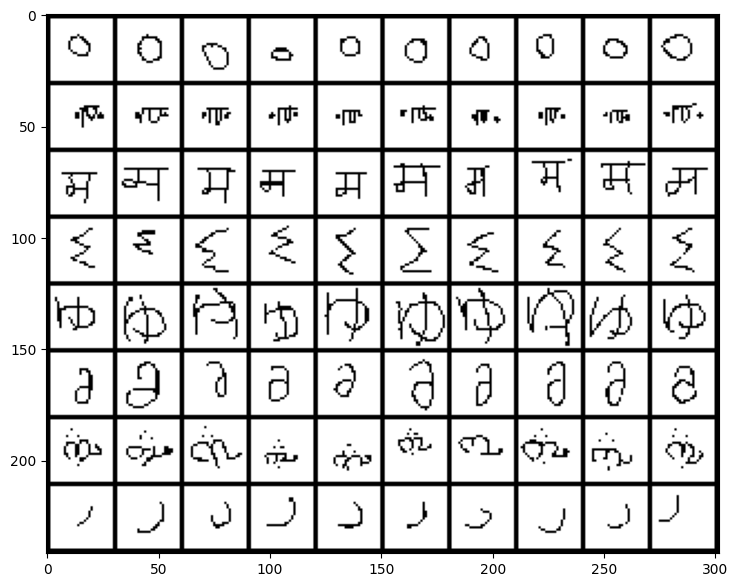

In [13]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [14]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels=64):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, x_dim=(3, 28, 28), hid_dim=64, z_dim=64):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            ConvBlock(x_dim[0], hid_dim),
            ConvBlock(hid_dim, hid_dim),
            ConvBlock(hid_dim, hid_dim),
            ConvBlock(hid_dim, z_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)


### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [16]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images'].to(device)
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        n_total = n_support + n_query
        x = sample_images.view(n_way * n_total, *sample_images.shape[2:])
        embeddings = self.encoder(x)  # shape: (n_way * n_total, 64)

        # разложим обратно
        embeddings = embeddings.view(n_way, n_total, -1)  # (n_way, n_total, 64)
        support = embeddings[:, :n_support, :]             # (n_way, n_support, 64)
        query = embeddings[:, n_support:, :]               # (n_way, n_query, 64)

        # Вычисляем прототипы: среднее по support
        prototypes = support.mean(dim=1)                   # (n_way, 64)

        # Сравниваем каждый query со всеми прототипами
        query = query.contiguous().view(n_way * n_query, -1)       # (n_way * n_query, 64)
        dists = torch.cdist(query, prototypes)                     # (n_way * n_query, n_way)

        # Предсказание: класс с минимальной дистанцией
        y_hat = (-dists).softmax(dim=1)                            # вероятности
        preds = dists.argmin(dim=1)                                # предсказанные метки

        # правильные классы
        gt = torch.arange(n_way).unsqueeze(1).expand(n_way, n_query).reshape(-1).cuda()  # (n_way * n_query)

        loss_val = F.cross_entropy(-dists, gt)
        acc_val = (preds == gt).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
            }

In [17]:
def load_protonet_conv(x_dim=(3, 28, 28), hid_dim=64, z_dim=64):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = Encoder(x_dim=x_dim, hid_dim=hid_dim, z_dim=z_dim)

    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [18]:
# !pip install wandb

In [19]:
import wandb
# wandb.login()

In [26]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    wandb.init(
        project="PrototypicalNetwork",
        name="train_model",
        config={
            "n_way": n_way,
            "n_support": n_support,
            "n_query": n_query,
            "max_epoch": max_epoch,
            "epoch_size": epoch_size,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0]['lr']
        }
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0
    stop = False

    history_loss = []
    history_acc = []

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size

        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, epoch_loss, epoch_acc))

        wandb.log({"loss": epoch_loss, "accuracy": epoch_acc, "lr": optimizer.param_groups[0]['lr']})

        history_loss.append(epoch_loss)
        history_acc.append(epoch_acc)

        epoch += 1
        scheduler.step()
    wandb.finish()

In [27]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 666

In [28]:
%%time

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train:   0%|          | 0/666 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.2171 Acc: 0.9528


Epoch 2 train:   0%|          | 0/666 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0537 Acc: 0.9866


Epoch 3 train:   0%|          | 0/666 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0367 Acc: 0.9906


Epoch 4 train:   0%|          | 0/666 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0288 Acc: 0.9928


Epoch 5 train:   0%|          | 0/666 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0257 Acc: 0.9935


accuracy,▁▇███
loss,█▂▁▁▁
lr,█▄▂▁▁
accuracy,0.9935
loss,0.02573
lr,6e-05


CPU times: user 4min 22s, sys: 28.7 s, total: 4min 50s
Wall time: 4min 55s


## Test

In [29]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [30]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [31]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0226 Acc: 0.9933


## Test on specific example

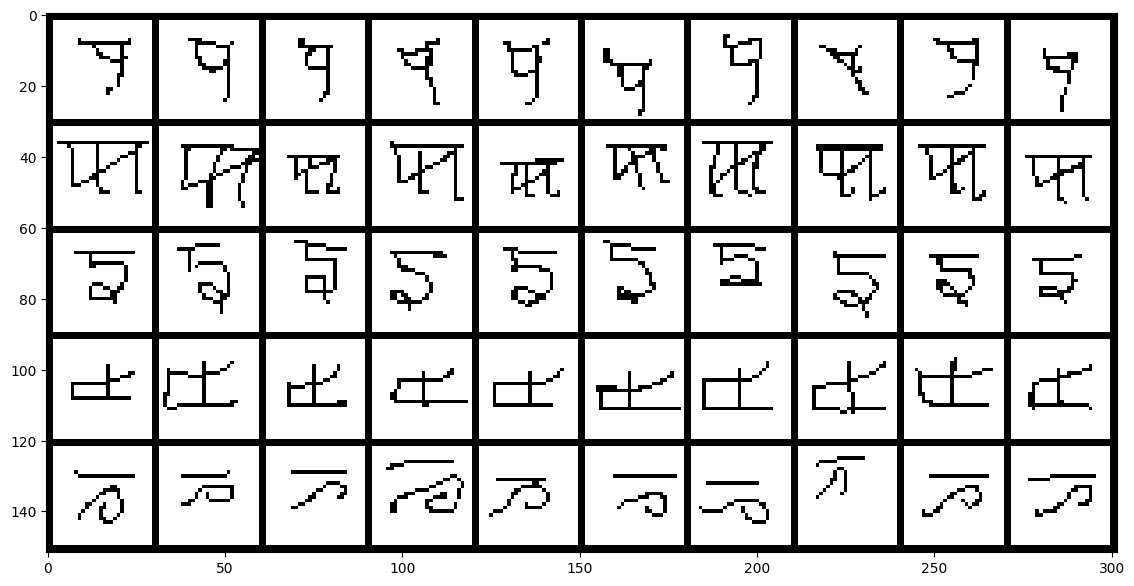

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [ ]:
def display_prediction(sample, y_hat):
    """
    Отображает support и query изображения с классами и предсказаниями
    sample: dict с 'images', 'n_way', 'n_support', 'n_query'
    y_hat: torch.Tensor с предсказаниями (shape: n_way * n_query, n_way)
    """
    images = sample['images']  # (n_way, n_support + n_query, C, H, W)
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    images_np = images.cpu().numpy()
    images_np = images_np.transpose(0, 1, 3, 4, 2)  # (n_way, n_sup+query, H, W, C)
    images_np = images_np / images_np.max()  # нормализация для отображения

    fig, axes = plt.subplots(n_way, n_support + n_query, figsize=(2*(n_support + n_query), 2*n_way))

    for i in range(n_way):
        # Support картинки
        for j in range(n_support):
            ax = axes[i, j]
            ax.imshow(images_np[i, j])
            ax.axis('off')
            ax.set_title(f'Sup cls={i}', fontsize=8, color='black')

        # Query картинки + предсказанные классы
        for j in range(n_query):
            ax = axes[i, j + n_support]
            ax.imshow(images_np[i, j + n_support])
            ax.axis('off')
            pred_cls = y_hat[i * n_query + j].argmax().item()
            if i == pred_cls:
                c = 'green'
            else:
                c = 'red'
            ax.set_title(f'Q cls={i} / pred={pred_cls}', fontsize=8, color=c)

    plt.tight_layout()
    plt.show()


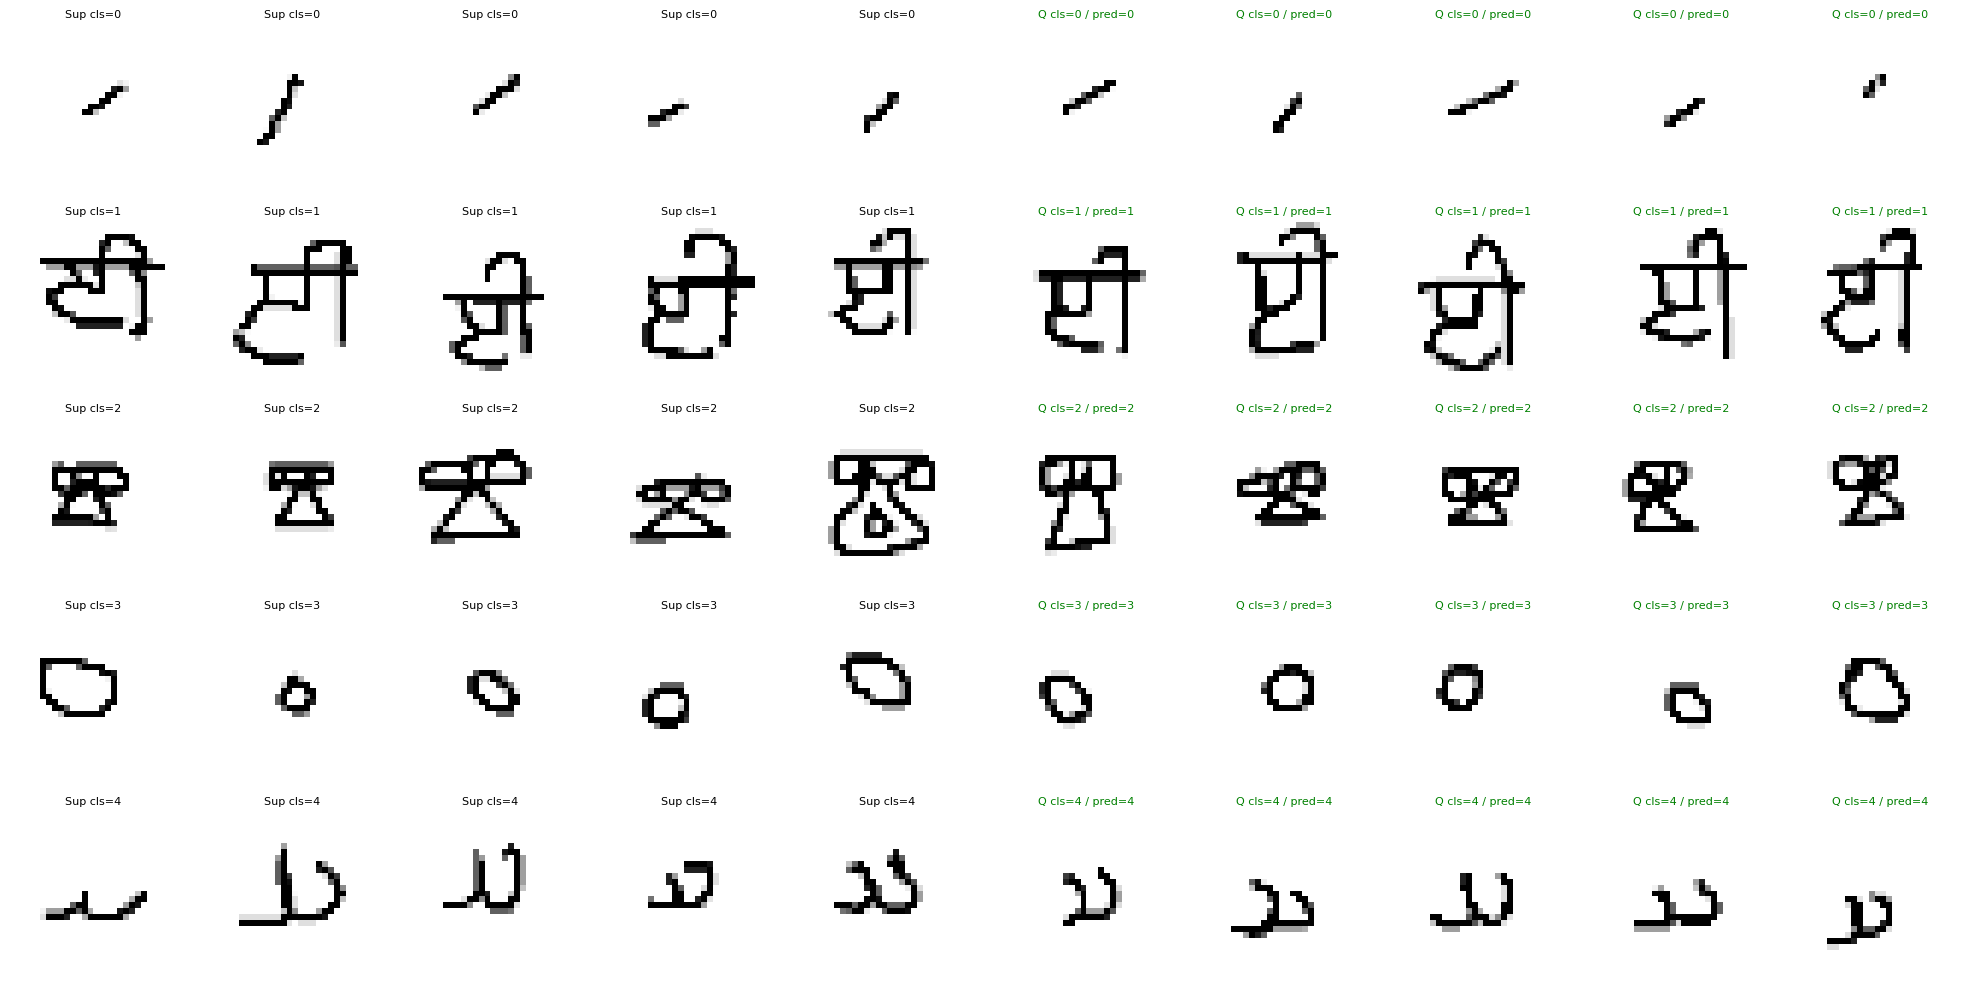

In [ ]:
sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
loss, output = model.set_forward_loss(sample)
display_prediction(sample, output['y_hat'])


# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [ ]:
# === Этап I: Подготовка данных ===

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt

# Сильные аугментации для SimCLR
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

# Стандартные аугментации для классификации
classifier_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Кастомный датасет для SimCLR
class ContrastiveDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        x_i = self.transform(img)
        x_j = self.transform(img)
        return x_i, x_j

    def __len__(self):
        return len(self.base_dataset)

# CIFAR-10 без transform
cifar_train_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
simclr_dataset = ContrastiveDataset(cifar_train_raw, simclr_transform)
simclr_loader = DataLoader(simclr_dataset, batch_size=256, shuffle=True, drop_last=True)

In [ ]:
# === Этап II: Обучение SimCLR ===

from torchvision.models import resnet18

class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.encoder = base_encoder
        dim_mlp = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(dim_mlp, dim_mlp),
            nn.ReLU(),
            nn.Linear(dim_mlp, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return F.normalize(projections, dim=1)

# NT-Xent loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature

    labels = torch.arange(N).cuda()
    labels = torch.cat([labels, labels], dim=0)
    mask = torch.eye(2 * N, dtype=torch.bool).cuda()
    sim = sim.masked_fill(mask, -9e15)

    positives = torch.cat([torch.diag(sim, N), torch.diag(sim, -N)], dim=0)
    nominator = torch.exp(positives)
    denominator = torch.sum(torch.exp(sim), dim=1)
    loss = -torch.log(nominator / denominator)
    return loss.mean()

# Обучение SimCLR
simclr_model = SimCLRModel(resnet18(weights='DEFAULT')).cuda()
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=1e-3)

def train_simclr(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_i, x_j in loader:
            x_i, x_j = x_i.cuda(), x_j.cuda()
            z_i = model(x_i)
            z_j = model(x_j)
            loss = nt_xent_loss(z_i, z_j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"SimCLR Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")

train_simclr(simclr_model, simclr_loader, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


SimCLR Epoch 1: Loss = 5.2193
SimCLR Epoch 2: Loss = 5.0688
SimCLR Epoch 3: Loss = 5.0259
SimCLR Epoch 4: Loss = 4.9989
SimCLR Epoch 5: Loss = 4.9845
SimCLR Epoch 6: Loss = 4.9616
SimCLR Epoch 7: Loss = 4.9486
SimCLR Epoch 8: Loss = 4.9383
SimCLR Epoch 9: Loss = 4.9314
SimCLR Epoch 10: Loss = 4.9248


In [ ]:
# === Этап III: Downstream задача (замороженный encoder) ===

class Classifier(nn.Module):
    def __init__(self, encoder, feature_dim=512, num_classes=10):
        super().__init__()
        self.encoder = encoder
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.fc(features)

# Prepare downstream data
full_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=classifier_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

classifier_model = Classifier(simclr_model.encoder).cuda()
criterion = nn.CrossEntropyLoss()
clf_optimizer = torch.optim.Adam(classifier_model.fc.parameters(), lr=1e-3)

def train_classifier_with_loss(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    for epoch in range(epochs):
        model.train()
        correct, total, total_loss = 0, 0, 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()
        train_acc.append(correct / total)
        train_loss.append(total_loss / len(train_loader))

        model.eval()
        correct, total, total_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.cuda(), y.cuda()
                logits = model(x)
                loss = criterion(logits, y)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
                total_loss += loss.item()
        val_acc.append(correct / total)
        val_loss.append(total_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")
    return train_acc, val_acc, train_loss, val_loss

simclr_train_acc, simclr_val_acc, simclr_train_loss, simclr_val_loss = train_classifier_with_loss(
    classifier_model, train_loader, val_loader, clf_optimizer, criterion, epochs=10
)

Epoch 1: Train Acc=0.5443, Val Acc=0.5770
Epoch 2: Train Acc=0.5854, Val Acc=0.5910
Epoch 3: Train Acc=0.5865, Val Acc=0.5835
Epoch 4: Train Acc=0.5921, Val Acc=0.5975
Epoch 5: Train Acc=0.5899, Val Acc=0.5980
Epoch 6: Train Acc=0.5923, Val Acc=0.6065
Epoch 7: Train Acc=0.6058, Val Acc=0.6045
Epoch 8: Train Acc=0.6028, Val Acc=0.5920
Epoch 9: Train Acc=0.6044, Val Acc=0.6065
Epoch 10: Train Acc=0.6088, Val Acc=0.6185


In [ ]:
# === Этап IV: Базовая модель (обучаем всё с нуля) ===

class ClassifierFromScratch(nn.Module):
    def __init__(self, feature_dim=512, num_classes=10):
        super().__init__()
        # self.encoder = resnet18(pretrained=False)
        self.encoder = resnet18()
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        return self.fc(features)

scratch_model = ClassifierFromScratch().cuda()
scratch_optimizer = torch.optim.Adam(scratch_model.parameters(), lr=1e-3)

scratch_train_acc, scratch_val_acc, scratch_train_loss, scratch_val_loss = train_classifier_with_loss(
    scratch_model, train_loader, val_loader, scratch_optimizer, criterion, epochs=10
)

Epoch 1: Train Acc=0.3546, Val Acc=0.4070
Epoch 2: Train Acc=0.4870, Val Acc=0.4730
Epoch 3: Train Acc=0.5540, Val Acc=0.5050
Epoch 4: Train Acc=0.6185, Val Acc=0.5245
Epoch 5: Train Acc=0.6719, Val Acc=0.5365
Epoch 6: Train Acc=0.7278, Val Acc=0.5440
Epoch 7: Train Acc=0.7821, Val Acc=0.5750
Epoch 8: Train Acc=0.8316, Val Acc=0.5650
Epoch 9: Train Acc=0.8556, Val Acc=0.5440
Epoch 10: Train Acc=0.8899, Val Acc=0.5675


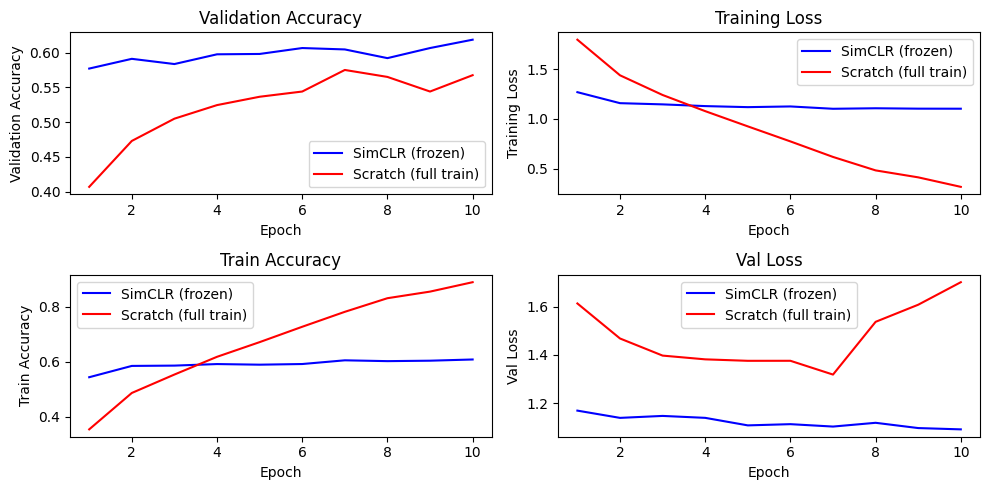

In [ ]:
# === Этап V: Визуализация ===

epochs = range(1, 11)
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(epochs, simclr_val_acc, label='SimCLR (frozen)', color='blue')
plt.plot(epochs, scratch_val_acc, label='Scratch (full train)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, simclr_train_loss, label='SimCLR (frozen)', color='blue')
plt.plot(epochs, scratch_train_loss, label='Scratch (full train)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, simclr_train_acc, label='SimCLR (frozen)', color='blue')
plt.plot(epochs, scratch_train_acc, label='Scratch (full train)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, simclr_val_loss, label='SimCLR (frozen)', color='blue')
plt.plot(epochs, scratch_val_loss, label='Scratch (full train)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.title('Val Loss')
plt.legend()


plt.tight_layout()
plt.show()